Epoch 1/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 339626208.0000 - val_loss: 390925312.0000
Epoch 2/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 336871904.0000 - val_loss: 351368256.0000
Epoch 3/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 283290400.0000 - val_loss: 295100704.0000
Epoch 4/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 173790544.0000 - val_loss: 191950144.0000
Epoch 5/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 139288224.0000 - val_loss: 158399120.0000
Epoch 6/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 131274352.0000 - val_loss: 124518640.0000
Epoch 7/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 92278464.0000 - val_loss: 93327528.0000
Epoch 8/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 70668312.0000 - val_loss: 66144304.0000
Epoch 9/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 37771852.0000 - val_loss: 44051116.0000
Epoch 10/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 32638698.0000 - val_loss: 2630

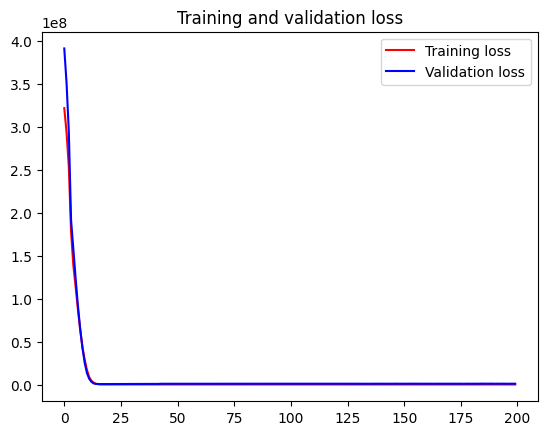

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Train data RMSE:  65002827.7800572
Train data MSE:  4225367600000000.0
Train data MAE:  26975836.0
-------------------------------------------------------------------------------------
Test data RMSE:  63955178.521409385
Test data MSE:  4090264900000000.0
Test data MAE:  43305948.0
Train data explained variance regression score: 0.9963622093200684
Test data explained variance regression score: 0.9912581443786621


In [ ]:
import pandas as pd
import numpy as np
import datetime
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score
import math

# Load and preprocess data
df = pd.read_csv('BTC-USD.csv')
df = df[['Date', 'Close']]
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')

# Set 'Date' as index
df.set_index('Date', inplace=True)

# Define the windowing function
def df_to_windowed_df(dataframe, first_date_str, last_date_str, n=3):
    first_date = pd.to_datetime(first_date_str)
    last_date = pd.to_datetime(last_date_str)
    target_date = first_date
    dates = []
    X, Y = [], []

    while True:
        df_subset = dataframe.loc[:target_date].tail(n+1)
        if len(df_subset) != n+1:
            print(f'Error: Window of size {n} is too large for date {target_date}')
            return

        close_values = df_subset['Close'].to_numpy()
        x = close_values[:-1].reshape(-1, 1)
        y = close_values[-1]

        dates.append(target_date)
        X.append(x)
        Y.append(y)

        next_week = dataframe.loc[target_date:target_date + datetime.timedelta(days=7)]
        if next_week.empty:
            break

        next_date = next_week.index[-1] + datetime.timedelta(days=1)
        if next_date > last_date:
            break

        target_date = next_date

    ret_df = pd.DataFrame({})
    ret_df['Target Date'] = dates
    X = np.array(X)
    for i in range(0, n):
        ret_df[f'Target-{n-i}'] = X[:, i, 0]

    ret_df['Target'] = Y
    return ret_df

# Create windowed data
windowed_df = df_to_windowed_df(df, '2014-09-24', '2024-03-17', n=3)

# Convert to numpy arrays
def windowed_df_to_date_X_y(windowed_dataframe):
    df_as_np = windowed_dataframe.to_numpy()
    dates = df_as_np[:, 0]
    middle_matrix = df_as_np[:, 1:-1]
    X = middle_matrix.reshape((len(dates), 3, 1))
    Y = df_as_np[:, -1]
    return dates, X.astype(np.float32), Y.astype(np.float32)

dates, X, y = windowed_df_to_date_X_y(windowed_df)

# Split data
q_80 = int(len(dates) * .8)
q_90 = int(len(dates) * .9)

dates_train, X_train, y_train = dates[:q_80], X[:q_80], y[:q_80]
dates_val, X_val, y_val = dates[q_80:q_90], X[q_80:q_90], y[q_80:q_90]
dates_test, X_test, y_test = dates[q_90:], X[q_90:], y[q_90:]

# Define the N-BEATS model
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LSTM

def build_nbeats_model(input_shape):
    inputs = Input(shape=input_shape)
    x = LSTM(10, activation='relu')(inputs)
    x = Dense(50, activation='relu')(x)
    x = Dense(1)(x)
    model = Model(inputs, x)
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

model = build_nbeats_model((3, 1))

# Train the model
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=200, batch_size=32, verbose=1)

# Plot training and validation loss
plt.plot(history.history['loss'], 'r', label='Training loss')
plt.plot(history.history['val_loss'], 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

# Predict and evaluate
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

scaler = MinMaxScaler()
scaler.fit(y_train.reshape(-1, 1))
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
original_ytrain = scaler.inverse_transform(y_train.reshape(-1, 1))
original_ytest = scaler.inverse_transform(y_test.reshape(-1, 1))

print("Train data RMSE: ", math.sqrt(mean_squared_error(original_ytrain, train_predict)))
print("Train data MSE: ", mean_squared_error(original_ytrain, train_predict))
print("Train data MAE: ", mean_absolute_error(original_ytrain, train_predict))
print("-------------------------------------------------------------------------------------")
print("Test data RMSE: ", math.sqrt(mean_squared_error(original_ytest, test_predict)))
print("Test data MSE: ", mean_squared_error(original_ytest, test_predict))
print("Test data MAE: ", mean_absolute_error(original_ytest, test_predict))

print("Train data explained variance regression score:", explained_variance_score(original_ytrain, train_predict))
print("Test data explained variance regression score:", explained_variance_score(original_ytest, test_predict))




2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


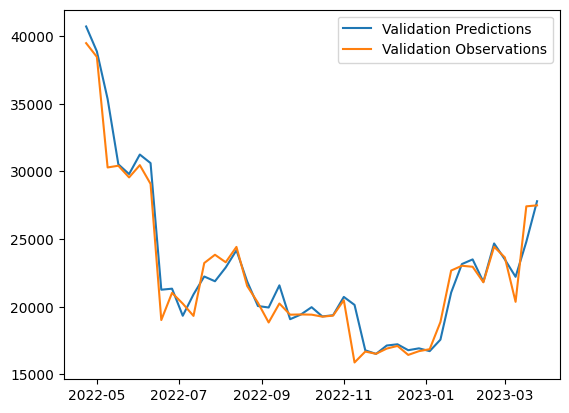

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


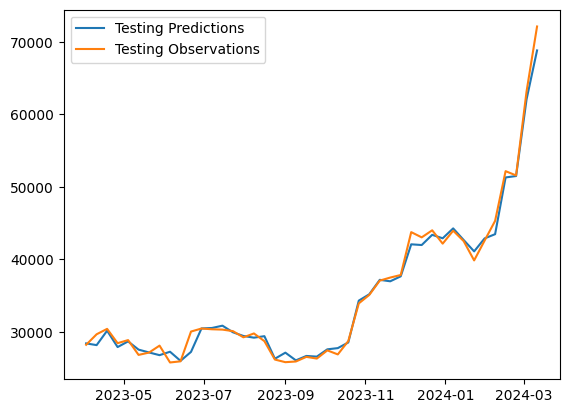

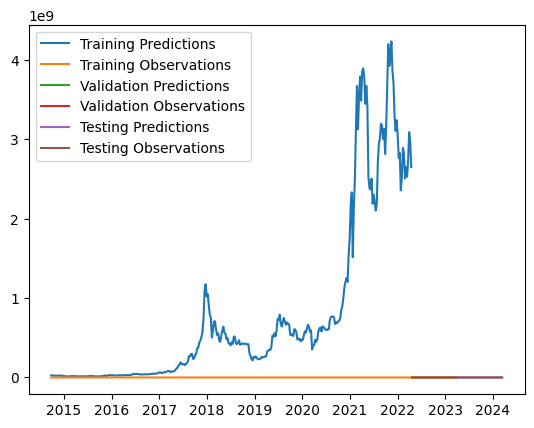

In [ ]:
# Plot predictions vs observations
val_predictions = model.predict(X_val).flatten()
plt.plot(dates_val, val_predictions, label='Validation Predictions')
plt.plot(dates_val, y_val, label='Validation Observations')
plt.legend()
plt.show()

test_predictions = model.predict(X_test).flatten()
plt.plot(dates_test, test_predictions, label='Testing Predictions')
plt.plot(dates_test, y_test, label='Testing Observations')
plt.legend()
plt.show()

plt.plot(dates_train, train_predict, label='Training Predictions')
plt.plot(dates_train, y_train, label='Training Observations')
plt.plot(dates_val, val_predictions, label='Validation Predictions')
plt.plot(dates_val, y_val, label='Validation Observations')
plt.plot(dates_test, test_predictions, label='Testing Predictions')
plt.plot(dates_test, y_test, label='Testing Observations')
plt.legend()
plt.show()